# RAF-DB - all classes
**Author**: Johannes S. Fischer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime

In [2]:
model_name = 'RAF-impr-std'

Load pretrained model to fine-tune it? If yes, specify model name, if no set it to ```None```.

In [3]:
pretrained_model_name = None

# Data

## Preprocessing Function
Preprocessing function like for VGG16, where pixel values per channel are normalized to have zero mean (```tensorflow``` implementation can be found [here](https://github.com/keras-team/keras/blob/2c48a3b38b6b6139be2da501982fd2f61d7d48fe/keras/applications/imagenet_utils.py#L168)).

In [4]:
# RAF-DB training data mean and std
mean = [146.6770, 114.6274, 102.3102]
std = [67.6282, 61.7651, 61.3665]

def preprocess(x):
    # ensure image format
    x = np.array(x, dtype='float32')
    
    # normalize
    x[..., 0] -= mean[0]
    x[..., 1] -= mean[1]
    x[..., 2] -= mean[2]
    if std is not None:
        x[..., 0] /= std[0]
        x[..., 1] /= std[1]
        x[..., 2] /= std[2] 
    return x

def de_preprocess(x):
    if std is not None:
        x[..., 0] *= std[0]
        x[..., 1] *= std[1]
        x[..., 2] *= std[2]
    # normalize
    x[..., 0] += mean[0]
    x[..., 1] += mean[1]
    x[..., 2] += mean[2]
    return x.astype('uint8')

## Load Data

In [5]:
%%time

from Dataloader import load_RAF_targetvector

# settings
DATA_DIR = './data/RAF/'

IMG_SIZE = (100, 100)
IMG_SHAPE = IMG_SIZE + (3,)

BATCH_SIZE = 64

# load data
train_ds, val_ds, test_ds = load_RAF_targetvector(DATA_DIR,
                                                  target_img_size=IMG_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  preprocessing_function=preprocess)

Splitting testing dataset into stratified validation and training set
Training
- (12271, 100, 100, 3) 
- (12271, 7)
Validation
- (1534, 100, 100, 3) 
- (1534, 7)
Testing
- (1534, 100, 100, 3) 
- (1534, 7)
Wall time: 9.91 s


Prepare some function to get labels...

In [6]:
emotion_labels = ['surprise', 'fear', 'disgust', 'happiness', 'sadness', 'anger', 'neutral']

num_classes = len(emotion_labels)
print("Number of classes: ", num_classes)

def vec2label(onehot_vec):
    major_vote = np.argmax(onehot_vec)
    return emotion_labels[major_vote]

Number of classes:  7


## Data Examples

Show some examples...

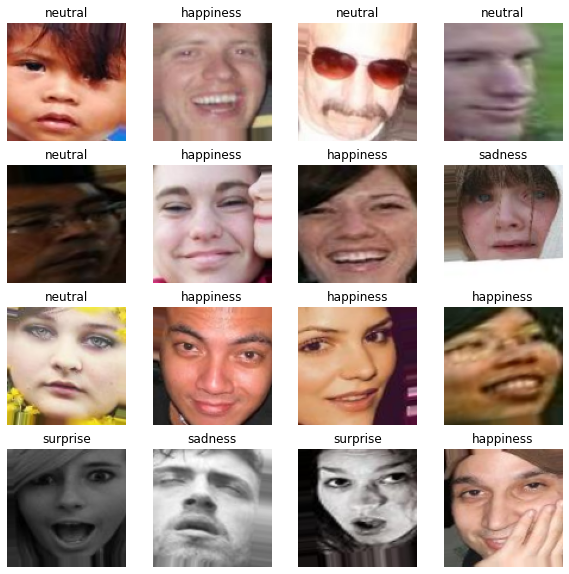

In [7]:
images, labels = next(train_ds)

plt.subplots(4,4, figsize=(10, 10))
for i in range(16):
    plt.subplot(4,4, i+1)
    plt.imshow(
        de_preprocess(images[i])
    )
    plt.title(vec2label(labels[i]))
    plt.axis('off')
plt.show()

# Model

## Base model
Architecture of the model without classification layer.

In [8]:
from ModelGenerator import get_base_model2

# get base model
model = get_base_model2(IMG_SHAPE)

## Classification model
Add classification layer to the base model.

In [9]:
# add classification layer (softmax)
model.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="softmax"))

# load pretrained version if required
if pretrained_model_name is not None:
    model.load_weights(f'./models/{pretrained_model_name}')

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (ConvLayer)     (None, 100, 100, 64)      2048      
_________________________________________________________________
block1_conv2 (ConvLayer)     (None, 100, 100, 64)      37184     
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 33, 33, 64)        0         
_________________________________________________________________
block2_conv1 (ConvLayer)     (None, 33, 33, 96)        55776     
_________________________________________________________________
block2_conv2 (ConvLayer)     (None, 33, 33, 96)        83424     
_________________________________________________________________
block2_conv3 (ConvLayer)     (None, 33, 33, 96)        83424     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 11, 11, 96)        0

# Training

In [10]:
# callbacks
dt = datetime.now().strftime("%m%d-%H%M")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=f"./modelcheckpoints/{model_name}_{dt}",
                                       monitor='val_accuracy',
                                       save_best_only=True,
                                       verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.1,
                                         patience=4,
                                         verbose=1,
                                         mode='auto',
                                         min_lr=0.00000001),
    tf.keras.callbacks.CSVLogger(f'./log/{model_name}_{dt}.csv',
                                 separator=",", append=True)
]

In [11]:
%%time

epochs = 35

history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=callbacks)

Epoch 1/35
192/192 [==============================] - 49s 231ms/step - loss: 1.5607 - accuracy: 0.4172 - val_loss: 1.6484 - val_accuracy: 0.4218

Epoch 00001: val_accuracy improved from -inf to 0.42177, saving model to ./modelcheckpoints\RAF-impr-std_0124-1008


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF-impr-std_0124-1008\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF-impr-std_0124-1008\assets


Epoch 2/35
192/192 [==============================] - 43s 223ms/step - loss: 1.2862 - accuracy: 0.5730 - val_loss: 1.4428 - val_accuracy: 0.5671

Epoch 00002: val_accuracy improved from 0.42177 to 0.56714, saving model to ./modelcheckpoints\RAF-impr-std_0124-1008


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF-impr-std_0124-1008\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF-impr-std_0124-1008\assets


Epoch 3/35
192/192 [==============================] - 43s 224ms/step - loss: 1.1460 - accuracy: 0.6513 - val_loss: 1.5001 - val_accuracy: 0.5287

Epoch 00003: val_accuracy did not improve from 0.56714
Epoch 4/35
192/192 [==============================] - 42s 220ms/step - loss: 1.0792 - accuracy: 0.6920 - val_loss: 1.5236 - val_accuracy: 0.5222

Epoch 00004: val_accuracy did not improve from 0.56714
Epoch 5/35
192/192 [==============================] - 42s 220ms/step - loss: 1.0420 - accuracy: 0.7168 - val_loss: 1.1962 - val_accuracy: 0.5828

Epoch 00005: val_accuracy improved from 0.56714 to 0.58279, saving model to ./modelcheckpoints\RAF-impr-std_0124-1008


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF-impr-std_0124-1008\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF-impr-std_0124-1008\assets


Epoch 6/35
192/192 [==============================] - 43s 224ms/step - loss: 1.0094 - accuracy: 0.7381 - val_loss: 1.0062 - val_accuracy: 0.7477

Epoch 00006: val_accuracy improved from 0.58279 to 0.74772, saving model to ./modelcheckpoints\RAF-impr-std_0124-1008


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF-impr-std_0124-1008\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF-impr-std_0124-1008\assets


Epoch 7/35
192/192 [==============================] - 43s 223ms/step - loss: 0.9891 - accuracy: 0.7580 - val_loss: 1.0914 - val_accuracy: 0.7562

Epoch 00007: val_accuracy improved from 0.74772 to 0.75619, saving model to ./modelcheckpoints\RAF-impr-std_0124-1008


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF-impr-std_0124-1008\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF-impr-std_0124-1008\assets


Epoch 8/35
192/192 [==============================] - 43s 225ms/step - loss: 0.9703 - accuracy: 0.7657 - val_loss: 1.0181 - val_accuracy: 0.7425

Epoch 00008: val_accuracy did not improve from 0.75619
Epoch 9/35
192/192 [==============================] - 43s 224ms/step - loss: 0.9561 - accuracy: 0.7765 - val_loss: 1.0824 - val_accuracy: 0.6943

Epoch 00009: val_accuracy did not improve from 0.75619
Epoch 10/35
192/192 [==============================] - 42s 219ms/step - loss: 0.9443 - accuracy: 0.7829 - val_loss: 1.0260 - val_accuracy: 0.7399

Epoch 00010: val_accuracy did not improve from 0.75619

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/35
192/192 [==============================] - 43s 225ms/step - loss: 0.8997 - accuracy: 0.8115 - val_loss: 0.8973 - val_accuracy: 0.8201

Epoch 00011: val_accuracy improved from 0.75619 to 0.82008, saving model to ./modelcheckpoints\RAF-impr-std_0124-1008


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF-impr-std_0124-1008\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF-impr-std_0124-1008\assets


Epoch 12/35
192/192 [==============================] - 43s 226ms/step - loss: 0.8880 - accuracy: 0.8240 - val_loss: 0.8958 - val_accuracy: 0.8253

Epoch 00012: val_accuracy improved from 0.82008 to 0.82529, saving model to ./modelcheckpoints\RAF-impr-std_0124-1008


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF-impr-std_0124-1008\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF-impr-std_0124-1008\assets


Epoch 13/35
192/192 [==============================] - 44s 226ms/step - loss: 0.8818 - accuracy: 0.8279 - val_loss: 0.8923 - val_accuracy: 0.8253

Epoch 00013: val_accuracy did not improve from 0.82529
Epoch 14/35
192/192 [==============================] - 43s 225ms/step - loss: 0.8779 - accuracy: 0.8269 - val_loss: 0.9057 - val_accuracy: 0.8194

Epoch 00014: val_accuracy did not improve from 0.82529
Epoch 15/35
192/192 [==============================] - 42s 220ms/step - loss: 0.8736 - accuracy: 0.8296 - val_loss: 0.9021 - val_accuracy: 0.8214

Epoch 00015: val_accuracy did not improve from 0.82529
Epoch 16/35
192/192 [==============================] - 42s 220ms/step - loss: 0.8711 - accuracy: 0.8330 - val_loss: 0.9072 - val_accuracy: 0.8044

Epoch 00016: val_accuracy did not improve from 0.82529
Epoch 17/35
192/192 [==============================] - 42s 220ms/step - loss: 0.8683 - accuracy: 0.8374 - val_loss: 0.9177 - val_accuracy: 0.8070

Epoch 00017: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF-impr-std_0124-1008\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF-impr-std_0124-1008\assets


Epoch 19/35
192/192 [==============================] - 44s 226ms/step - loss: 0.8594 - accuracy: 0.8420 - val_loss: 0.8895 - val_accuracy: 0.8351

Epoch 00019: val_accuracy improved from 0.83312 to 0.83507, saving model to ./modelcheckpoints\RAF-impr-std_0124-1008


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF-impr-std_0124-1008\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF-impr-std_0124-1008\assets


Epoch 20/35
192/192 [==============================] - 43s 224ms/step - loss: 0.8597 - accuracy: 0.8407 - val_loss: 0.8932 - val_accuracy: 0.8338

Epoch 00020: val_accuracy did not improve from 0.83507
Epoch 21/35
192/192 [==============================] - 44s 227ms/step - loss: 0.8598 - accuracy: 0.8398 - val_loss: 0.8905 - val_accuracy: 0.8331

Epoch 00021: val_accuracy did not improve from 0.83507
Epoch 22/35
192/192 [==============================] - 43s 222ms/step - loss: 0.8577 - accuracy: 0.8418 - val_loss: 0.8916 - val_accuracy: 0.8331

Epoch 00022: val_accuracy did not improve from 0.83507
Epoch 23/35
192/192 [==============================] - 45s 234ms/step - loss: 0.8571 - accuracy: 0.8439 - val_loss: 0.8910 - val_accuracy: 0.8338

Epoch 00023: val_accuracy did not improve from 0.83507

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 24/35
192/192 [==============================] - 43s 224ms/step - loss: 0.8577 - accuracy: 0.8443 - val_

INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF-impr-std_0124-1008\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF-impr-std_0124-1008\assets



Epoch 00035: ReduceLROnPlateau reducing learning rate to 1e-08.
Wall time: 25min 55s


# Results

## Training Results

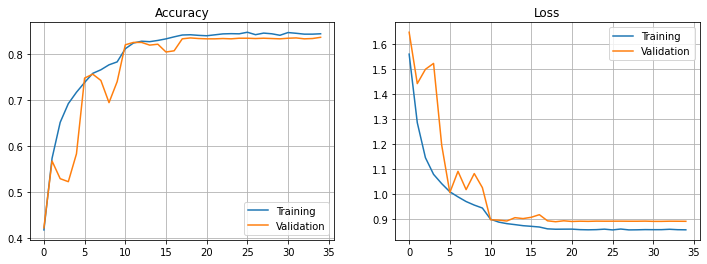

In [12]:
plt.figure(figsize=(12, 4))
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.grid(); plt.legend()
# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.grid(); plt.legend()
plt.show()

## Test Results

In [13]:
loss, acc = model.evaluate(test_ds, verbose=2)

print("\nAccuracy:\t%.2f%%" % (acc * 100))
print("Loss:\t\t%.4f" % (loss))

24/24 - 2s - loss: 0.9034 - accuracy: 0.8207

Accuracy:	82.07%
Loss:		0.9034


# Save Model

In [14]:
if True:
    model.save_weights('./models/' + model_name + "_" + dt + '_weights.h5')
    model.save("./models/" + model_name + "_" + dt + "/")
    f = open("./models/info.txt", "a")
    txt = model_name + "_" + dt + ": val=" + str(np.max(history.history['val_accuracy'])*100)
    txt += "; test=" + str(acc*100) + "\n"
    f.write(txt)
    f.close()

INFO:tensorflow:Assets written to: ./models/RAF-impr-std_0124-1008/assets


INFO:tensorflow:Assets written to: ./models/RAF-impr-std_0124-1008/assets


---